# AB-test

**Conditions**

For the test group was offered a new mechanism for paying for services on site. The control group remained with the basic mechanism.

The task is to analyze results of experiment and decide wether it is worth launching a new payment mechanism for all users.

**Data**

groups.csv - a file with information whether user belongs to the control group (A) or to the test group (B)

groups_add.csv - an additional file with users that was sent 2 days after data transfer

active_studs.csv - a file with information about users who logged into the platform on the days of the experiment

checks.csv - a file with information about user payments on the days of the experiment

# Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import norm
from tqdm.auto import tqdm
from scipy.stats import chi2_contingency, chisquare

In [2]:
# plot settings
sns.set(rc={'figure.figsize': (10, 5),
            'axes.titlesize': 18,
            'axes.labelsize': 14}, 
        style="whitegrid")


In [3]:
# metrics calculation
def metrics(df_stud):
    # df_stud is df with student id, payment and group of test
    
    # group A 
    a_group = df_stud[df_stud.grp == 'A']
    cr_a = a_group[a_group.rev == a_group.rev].shape[0] / a_group.shape[0]     
    arpu_a = a_group.rev.sum() / a_group.shape[0]
    arppu_a = a_group.rev.sum() / a_group[a_group.rev == a_group.rev].shape[0]
    
    # visualization of revenue distribution in the group A
    ax = sns.displot(data=a_group, x='rev')
    plt.xlabel('revenue')
    plt.ylabel('count')
    plt.title("Revenue distribution in group A")
    plt.show()
        
    # group B
    b_group = df_stud[df_stud.grp == 'B']
    cr_b = b_group[b_group.rev == b_group.rev].shape[0] / b_group.shape[0]     
    arpu_b = b_group.rev.sum() / b_group.shape[0]
    arppu_b = b_group.rev.sum() / b_group[b_group.rev == b_group.rev].shape[0]
    
    # visualization of revenue distribution in the group B
    ax = sns.displot(data=b_group, x='rev')
    plt.xlabel('revenue')
    plt.ylabel('count')
    plt.title("Revenue distribution in group B")
    plt.show()
           
    # table with all metrics
    metrics_by_group = pd.DataFrame({'cr': [cr_a, cr_b],
                                     'arpu': [arpu_a, arpu_b],
                                     'arppu': [arppu_a, arppu_b]}, index=['A', 'B'])
    
    # boxplot revenue distribution for both groups
    ax = sns.boxplot(data=df_stud, x='rev', y='grp')
    ax = sns.stripplot(data=df_stud, x='rev', y='grp', color='black')
    plt.xlabel('revenue')
    plt.ylabel('group')
    plt.title("Revenue distribution by groups")
    plt.show()
    
    # print table with metrics by groups
    print(f'Metrics by groups \n {metrics_by_group}')
    
    return metrics_by_group, a_group, b_group

In [4]:
# function for adding new data with groups and visualization metrics based on full data
def add_groups(df_stud, add_file):
    # df_stud - df with student id, payment and group of test
    # add_file - name of csv-file with additional information about groups
    
    # read data and set student id as index
    add_data = pd.read_csv(add_file)
    add_data.set_index(keys='id', inplace=True, drop=True)
    
    # add new groups to students
    df_stud = df_stud.fillna(add_data)
    
    # metrics calculation
    metrics_by_group, a_group, b_group = metrics(df_stud)
        
    return df_stud, metrics_by_group, a_group, b_group


In [5]:
# function that allows check hypothesis using bootsrtrap
def get_bootstrap(
    data_column_1, # numeric values of the first sample
    data_column_2, # numeric values of the second sample
    boot_it = 1000,# number of bootstrap-subsamples
    statistic = np.median, # the statiscics we are interested in
    bootstrap_conf_level = 0.95 # significance level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # extract subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # applying statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    # determine confidence interval
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    # p-value for distribution of difference values between statistics in two groups
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # visualization
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

# Data uploading

## Groups

In [6]:
groups = pd.read_csv('groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
# data size
groups.shape

(74484, 2)

In [8]:
# data types
groups.dtypes

id      int64
grp    object
dtype: object

In [9]:
# missing data
groups.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
# relative number of users in each group
groups.grp.value_counts(normalize=True)

B    0.803032
A    0.196968
Name: grp, dtype: float64

## Students

In [11]:
students = pd.read_csv('active_studs.csv')
students.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
# size
students.shape

(8341, 1)

In [13]:
# data types
students.dtypes

student_id    int64
dtype: object

In [14]:
# missing values
students.isna().sum()

student_id    0
dtype: int64

## Payment

In [15]:
checks = pd.read_csv('checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
# size
checks.shape

(541, 2)

In [17]:
# data types
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [18]:
# missing values
checks.isna().sum()

student_id    0
rev           0
dtype: int64

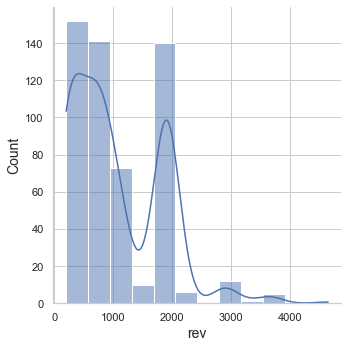

In [19]:
# revenue distribution
sns.displot(data=checks, x='rev', kde=True)

# Сhoising & calculation of metrics

To understand whether the new payment mechanism affects users behavior, compare the revenue in the control and test groups. 

For revenue estimation use the average revenue per paying user - **ARPPU**. ARPPU is the higher than higher the conversion rate from logged user to paying user - **CR** - and the average revenue per user - **ARPU**.

So ARPPU can be decomposed as: 
$$ARPU / (NumberOfUsers * CR)$$

**Calculate ARPPU, ARPU and CR for both of groups**

## Data Preparation

1. Join all data and leave only rows about students who logged on the days of the experiment.


2. Separate the new dataframe into 2: A-group & B-group.

In [20]:
# join students who logged on the days of the experiments with their payment
logged_students = students.merge(checks, how='left', on='student_id')
logged_students.head()

,student_id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN


In [21]:
# add groups and set dtudent id as index
groups.columns = ['student_id', 'grp']
logged_students = logged_students.merge(groups, how='left', on='student_id')
logged_students.set_index(keys='student_id', inplace=True, drop=True)
logged_students.head()

,rev,grp
student_id,,
581585,NaN,A
5723133,NaN,NaN
3276743,NaN,B
4238589,NaN,A
4475369,NaN,B


In [22]:
logged_students.shape

(8341, 2)

In [23]:
logged_students.isna().sum()

rev    7949
grp      13
dtype: int64

## Metrics calculation

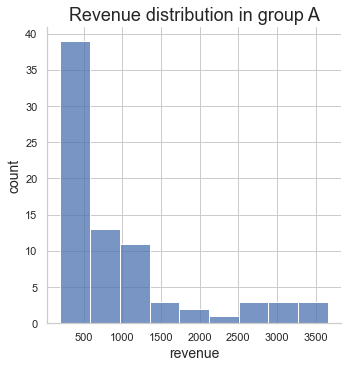

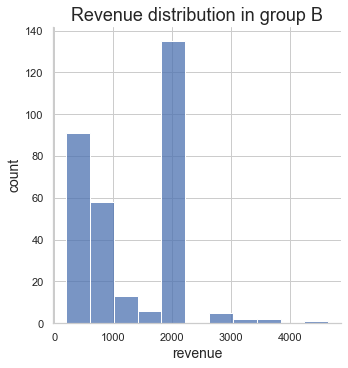

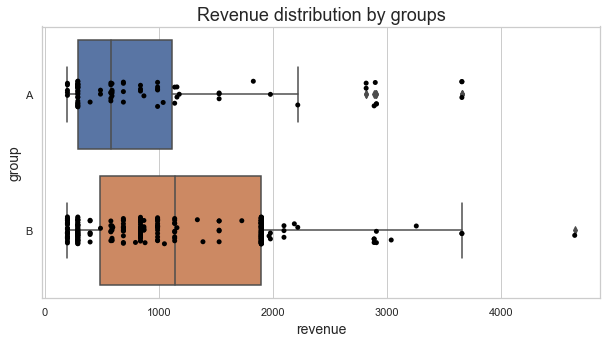

Metrics by groups 
          cr       arpu        arppu
A  0.050814  47.439739   933.589744
B  0.046077  57.864567  1255.827487


(         cr       arpu        arppu
 A  0.050814  47.439739   933.589744
 B  0.046077  57.864567  1255.827487,
             rev grp
 student_id         
 581585      NaN   A
 4238589     NaN   A
 1394612     NaN   A
 5194768     NaN   A
 3658923     NaN   A
 ...         ...  ..
 3208984     NaN   A
 2900558     NaN   A
 1161774     NaN   A
 5006972     NaN   A
 4037274     NaN   A
 
 [1535 rows x 2 columns],
               rev grp
 student_id           
 3276743       NaN   B
 4475369       NaN   B
 5481015       NaN   B
 1353433       NaN   B
 1170611       NaN   B
 ...           ...  ..
 1794344       NaN   B
 296883        NaN   B
 3598448       NaN   B
 3610547     290.0   B
 205705        NaN   B
 
 [6793 rows x 2 columns])

In [24]:
# calculate metrics using fuction 'metrics'
metrics(df_stud=logged_students)

## Additional file

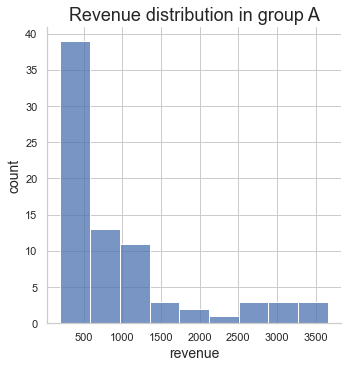

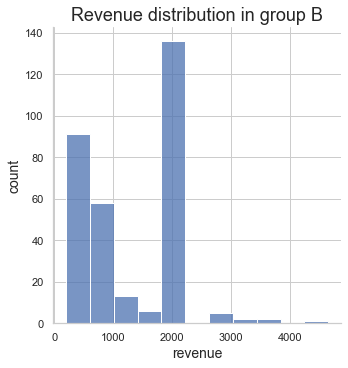

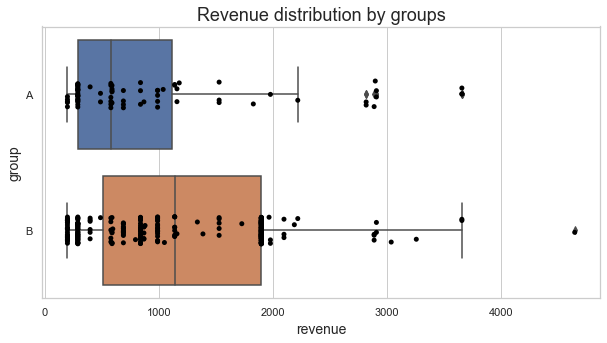

Metrics by groups 
          cr       arpu        arppu
A  0.050715  47.347204   933.589744
B  0.046156  58.058798  1257.878992


In [25]:
# add an additional file with groups and recalculate metrics
df_stud, metrics_by_group, a_group, b_group = add_groups(df_stud=logged_students, add_file='group_add.csv')

In [26]:
# missing values
df_stud.isna().sum()

rev    7949
grp       0
dtype: int64

# Comparison of metrics

As seen from the table 'Metrics by groups', CR in the test group is a little bit lower than in the control group and ARPU and ARPPU are higher in the test group. To determine if these differences are statistically significant or not, use:

1. Chi-squared test for CR 

2. Bootstrap for medians of revenue distribution in two groups. Median is chosen as measure of center as distribution in both group is not normal

## Chi-squared

In [27]:
metrics_by_group

,cr,arpu,arppu
A,0.050715,47.347204,933.589744
B,0.046156,58.058798,1257.878992


H0: no difference between number of paying and logged users in two groups

H1: there is a difference

In [28]:
# table for chi-square test contains number of paying users and number of logged users
table = [[metrics_by_group.cr.loc['A'] * a_group.shape[0], a_group.shape[0]],
         [metrics_by_group.cr.loc['B'] * b_group.shape[0], b_group.shape[0]]]

In [29]:
# chi-square and p-value
chi2, p, dof, ex = chi2_contingency(table)
p

0.5089998823014525

**As p > 0.05 there is no reason to reject H0.**

**This means that CR in group B is equal to CR in group A.**

## Bootstrap

H0 - no difference in medians of revenue distributions in two groups

H1 - there is difference in the medians

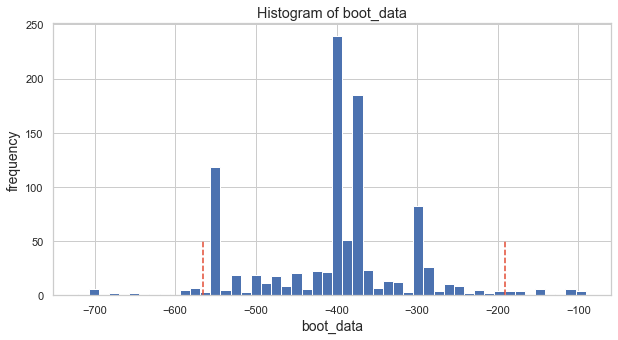

In [31]:
# use function 'get boostrap'
bootstrap_result = get_bootstrap(
                                data_column_1 = a_group.rev.dropna(), 
                                data_column_2 = b_group.rev.dropna(), 
                                boot_it = 1000,
                                statistic = np.median,
                                bootstrap_conf_level = 0.95
                            )

In [32]:
# confidence interval for values of difference between medians in two groups
bootstrap_result['ci']

,0
0.025,-565.1250
0.975,-190.9625


In [33]:
# p-value
bootstrap_result['p_value']

2.9951790765361806e-05

In [43]:
b_group.shape[0]

6803

**p_value < 0.05 and the confidence interval doesn't include 0. That means that we have enough reasons to reject H0, there are difference between medians in two groups.**

# Conclusions

An AB-test was conducted to test the new payment mechanism. Users were divided into 2 groups:
- the control group (A) saw the payment page unchanged;
- the test group (B) saw the new payment page.

Based on the data collected during the experiment, CR, ARPU and ARPPU were calculated. Below are the results.


|  |total users | logged users | paying users   | cr       | arpu      | arppu        | median revenue|
 --|----------  |------------- |-----------     | ---------|-----------| ----------   | ------------- |
|A | 14693      | 1538         | 78             | 0.050715 | 47.347204 |933.589744    | 585           |
|B | 59883      | 6803         | 314            | 0.046156 | 58.058798 |1257.878992   | 1140          |

As seen, conversion from a logged user to a paying user has not changed much, which was confirmed using the chi-squared test. This means **the new payment page does not encourage more logged users to purchase services on the platform.**

But ARPU and ARPPU were higher in the test group. To test whether these differences are statistically significant, medians of revenue were compared using bootstrap method. The resulting p-value turned out to be significantly less than 0.05, which makes it possible to reject H0 about the equality of the medians in the two groups. 

Based on calculated confidence interval, it can be assumed, that median revenue in test group is in the range from 775 to 1150. This means, that **the new payment page encourages users to make purchases that cost 1.3 to 2 times more than the old page does.**

**Based on AB-test, can be concluded that it is expedient to launch the new payment mechanism for all users.**
